# Planejamento da solução

-- Objetivo do problema: Previsão do primeiro destino que um novo usuário irá escolher

- Porque?
    - Qual tipo de modelo de negócio do Airbnb?
        - Marketplace ( Conectar pessoas que oferecem acomodacao, com pessoas que estao procurando acomodacao)
        - Oferta ( pessoas oferecendo acomodacao )
            - Tamanho do portfólio.
            - Diversidade/Densidade de Portfólio.
            - Preco Medio
            
        - Demanda ( pessoas procurando acomodacao )
            - Numero de Usuários
            - LTV ( Lifetime Value )
            - CAC ( Client Acquisition Cost )
            
           Gross Revenue = ( Fee*Numero cliente ) - CAC 

#
-- Proposta da Solucao
- Modelo de Predivao do primeiro destino de um novo usario.
- 1.0. Predicoes e salva em tabela do banco de dados. 
- 2.0. API 
    - Input: usuario e suas caracteristicas
    - Output: usuario e suas caracteristicas com a **predicao do destino**
        
--- Esperado 16 ciclos

# 0.0 Imports

In [1]:
import pickle
import pandas   as pd
import seaborn  as sns
from matplotlib import pyplot as plt

from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as me
from scikitplot import metrics      as mt

from keras      import models as ml
from keras      import layers as la

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [20, 8]
    plt.rcParams['font.size'] = 24
    plt.rcParams['figure.dpi'] = 100
    
    pd.set_option('display.float_format', lambda x: '%.3f' % x)
    
    # ignora future warnings
    #warnings.filterwarnings('ignore')
    
    sns.set()
    

## 0.2 Load Data

In [3]:
df_raw = pd.read_csv('../data/raw/train_users_2.csv', low_memory=False)
# df_sessions = pd.read_csv('../data/raw/sessions.csv', low_memory=False)

# 1.0 Data Description

In [4]:
df1 = df_raw.copy()

df1.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## 1.1 Data Dimension

In [5]:
print(f'number of rows: {df1.shape[0]}')
print(f'number of cols: {df1.shape[1]}')

number of rows: 213451
number of cols: 16


## 1.2 Data Types

In [6]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

## Check NA

In [7]:
df1.isna().sum()

id                              0
date_account_created            0
timestamp_first_active          0
date_first_booking         124543
gender                          0
age                         87990
signup_method                   0
signup_flow                     0
language                        0
affiliate_channel               0
affiliate_provider              0
first_affiliate_tracked      6065
signup_app                      0
first_device_type               0
first_browser                   0
country_destination             0
dtype: int64

## Replace NA

In [8]:
# for this cycle remove missing value completly
df1 = df1.dropna()
df1.shape

(68171, 16)

## Change Types

In [9]:
 # date_account_created
df1['date_account_created'] = pd.to_datetime( df1['date_account_created'] )

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime( df1['timestamp_first_active'], format='%Y%m%d%H%M%S' )

# date_first_booking
df1['date_first_booking'] = pd.to_datetime( df1['date_first_booking'] )

# age
df1['age'] = df1['age'].astype( 'int64' )

In [10]:
df1.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## Check Balanced Data

In [11]:
df1['country_destination'].value_counts( normalize=True )

US       0.708864
other    0.110854
FR       0.054085
IT       0.029763
GB       0.025935
ES       0.024864
CA       0.015696
DE       0.012454
NL       0.008801
AU       0.006366
PT       0.002318
Name: country_destination, dtype: float64

## Descriptive Statistical

In [12]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 1.7.1 Numerical Attributes

In [13]:
# Create metrics of central tendency and dispersion
d1 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).rename(columns={0: 'range'}).T
d2 = num_attributes.agg(['min', 'max', 'mean', 'median', 'std', 'skew', 'kurtosis'])

# concat all metrics
met = pd.concat([d1, d2]).T
met = met[['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]
met

,min,max,range,mean,median,std,skew,kurtosis
age,2.0,2014.0,2012.0,47.857593,33.0,146.036383,13.250136,175.132153
signup_flow,0.0,25.0,25.0,2.436857,0.0,6.534007,2.807117,6.439075


### 1.7.2 Categorical Attributes

# 2.0 Data Filtering

In [14]:
df2 = df1.copy()

## 2.1. Filtering Rows

## 2.2. Columns Selection

# 3.0 Feature Engineering

# 4.0 Exploratory Data Analysis

# 5.0 Data Preparation

In [15]:
df5 = df2.copy()

In [16]:
 # dummy variable
df5_dummy = pd.get_dummies(df5.drop(['id', 'country_destination'], axis=1 ) )

# join id
df5 = pd.concat( [df5[['id', 'country_destination']], df5_dummy], axis=1 )

In [17]:
X = df5.drop( 'country_destination', axis=1 )
y = df5['country_destination'].copy()

In [18]:
# Split dataset into training and test
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [19]:
#  # dummy variable
# X_test_dummy = pd.get_dummies(X_test.drop( ['id'], axis=1 ) )

# # join id and
# X_test = pd.concat( [X_test[['id']], X_test_dummy], axis=1 )

# 6.0 Feature Selection

In [20]:
cols_drop = ['date_account_created', 'timestamp_first_active', 'date_first_booking'] # original dates

df6_train = X_train.drop( cols_drop, axis=1 )

In [21]:
df6_test = X_test.drop( cols_drop, axis=1 )

In [27]:
# Saving Interim Data
df6_train.to_parquet('../data/interim/df6_train.parquet')
df6_test.to_parquet('../data/interim/df6_test.parquet')

pickle.dump(y_train, open('../data/interim/y_train.pkl', 'wb'))
pickle.dump(y_test, open('../data/interim/y_test.pkl', 'wb'))

# 7.0 Machine Learning Modelling

In [22]:
x_train = df6_train.drop( 'id', axis=1 )
x_test = df6_test.drop( 'id', axis=1 )

## 7.1 Neural Network MLP

In [23]:
ohe = pp.OneHotEncoder()
y_train_nn = ohe.fit_transform( y_train.values.reshape( -1, 1 ) ).toarray()

In [ ]:
# model definition
model = ml.Sequential()
model.add( la.Dense( 128, input_dim=x_train.shape[1], activation='relu' ) )
model.add( la.Dense( 11, activation='softmax') )

# model compile
model.compile( loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'] )

# train model
model.fit( x_train, y_train_nn, epochs=100 )

### 7.1.1 NN Performance

427/427 [==============================] - 0s 800us/step
Accuracy: 0.7061239457279062


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

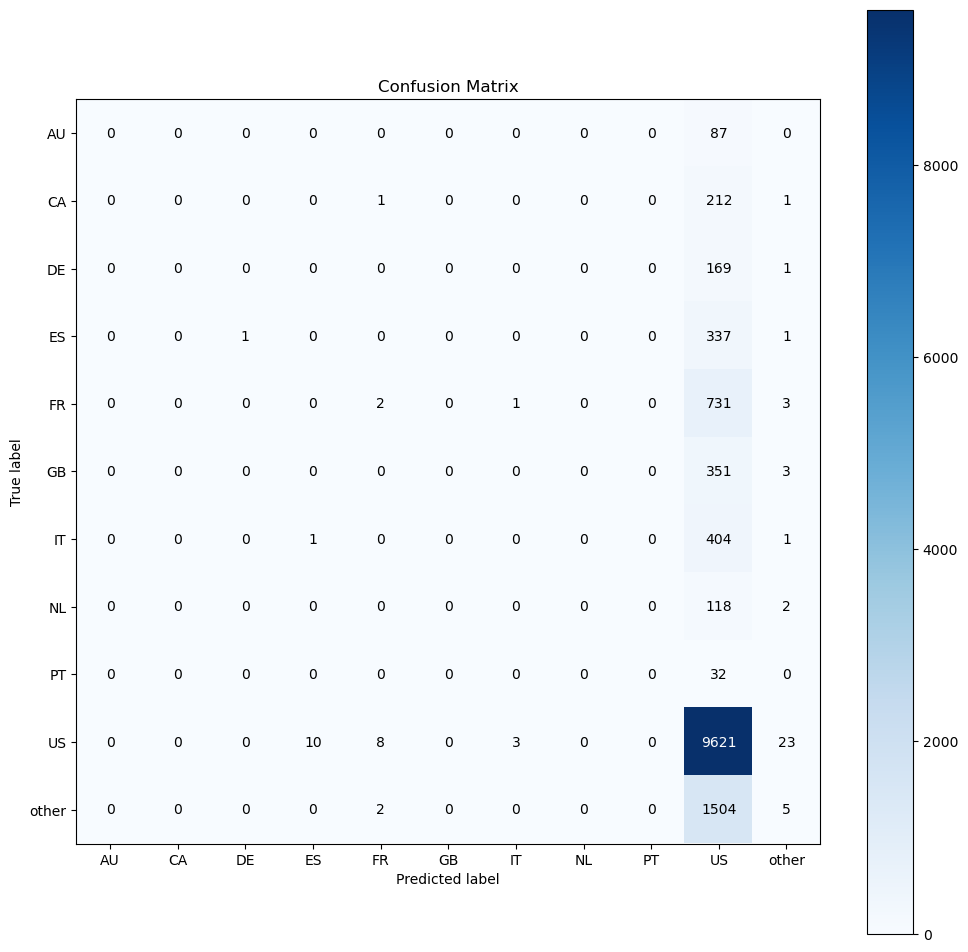

In [ ]:
 # prediction
pred_nn = model.predict( x_test )

# invert prediction
yhat_nn = ohe.inverse_transform( pred_nn )

# prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape( 1, -1 )[0]


# -------------------------- Metrics --------------------------
# Accuracy
acc_nn = me.accuracy_score( y_test_nn, yhat_nn )
print( 'Accuracy: {}'.format( acc_nn ) )

# Confusion Matrix
mt.plot_confusion_matrix( y_test_nn, yhat_nn, normalize=False, figsize=(12,12))


# Balanced Accuray
# F-Score Balanced
# Recall-Precison
# ROC 
# Kappa Metrics
# Matthew Metrics